In [1]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
filename = "datasets/original_dataset.xlsx"
df = pd.read_excel(filename, engine='openpyxl')


In [3]:
# data type & selecting feature(baseline model only used long-history feature)
numeric_features = ['Long_1', 'Long_2', 'Long_3', 'Long_4', 'Long_5', 'Long_6',
                    'Long_7', 'Long_8', 'Long_9', 'Long_10','Short_1','Short_2','Short_3','Short_4','Short_5','Short_6','Short_7','Short_8','Short_9','Short_10']

# using linear intepolation
for feature in numeric_features:
    # create a intepolation function
    interpolator = interp1d(df['submission_year'], df[feature], kind='linear', fill_value='extrapolate')
    
    # fill in NA，transforming the outcome to Series
    interpolated_values = pd.Series(interpolator(df['submission_year']), name=feature)
    
    # using fillna method to fill into NA
    df[feature].fillna(interpolated_values, inplace=True)

df

c:\Users\yanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\yanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\Users\yanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,410VKN,2015,0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017,1,Train_60,1600.0,0.0,0.0,338.0,3.0,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017,1,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017,1,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


In [4]:
# Impute the DataFrame
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015.0,0.0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
1,410VKN,2015.0,0.0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
2,394ETK,2015.0,1.0,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
3,036KQK,2015.0,0.0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
4,996RNP,2015.0,0.0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017.0,0.0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017.0,1.0,Train_60,1600.0,0.0,0.0,338.0,3.0,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017.0,1.0,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017.0,1.0,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


In [5]:
# Separate data into training and validation sets
train_df = df[df['TrainVal'] == 'Train_60']
val_df = df[df['TrainVal'] == 'Val_40']

# Separate features and target variable
X_train = train_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_train = train_df['target']

X_val = val_df.drop(columns=['UniqueID','submission_year', 'target', 'TrainVal'])
y_val = val_df['target']

feature_columns = X_train.columns

In [6]:
# Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the logistic regression model with L1 regularization
log_reg = LogisticRegression(penalty="l1", solver="liblinear")

# Set up the parameter grid for 'C', the inverse of regularization strength
param_grid = {'C': [0.001, 0.01, 0.1, 1]}

# Perform grid search with cross-validation using the normalized training data
clf = GridSearchCV(log_reg, param_grid, cv=5)
clf.fit(X_train_scaled, y_train)

# Output the best 'C' value found
print("Best C value:", clf.best_params_['C'])

# Retrieve the best model from the grid search
best_log_reg = clf.best_estimator_

# Perform feature selection using the model fitted on normalized data
model = SelectFromModel(best_log_reg, prefit=True)
X_train_new = model.transform(X_train_scaled)
X_val_new = model.transform(X_val_scaled)

# Get the mask of selected features
selected_features_bool = model.get_support()

# Apply this mask to the feature columns to get the names of selected features
selected_features = feature_columns[selected_features_bool]
print(selected_features)


Best C value: 0.1
Index(['Long_1', 'Long_2', 'Long_3', 'Long_4', 'Long_5', 'Long_6', 'Long_7',
       'Long_9', 'Short_1', 'Short_2', 'Short_3', 'Short_8', 'Short_10'],
      dtype='object')


In [7]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=2, shuffle=True, random_state=42)

X_train_old_list = []
X_train_new_list = []
X_train_full_list = []
y_train_list = []
valid_indices_list = [] 

# scaler
scaler_old = StandardScaler()
scaler_new = StandardScaler()
scaler_full = StandardScaler()

for train_index, valid_index in kf.split(train_df):
    train_fold = train_df.iloc[train_index]
    valid_indices_list.append(valid_index)  # Store the validation indices

    # For old features model
    X_train_old = train_fold.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                             'Short_1','Short_2','Short_3','Short_4','Short_5',
                             'Short_6','Short_7','Short_8','Short_9', 'Short_10', 'Long_8', 'Long_10'])
    X_train_old_list.append(X_train_old)

    # For new features model
    X_train_new = train_fold.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                           'Long_1','Long_2','Long_3','Long_4','Long_5','Long_6',
                                           'Long_7','Long_8','Long_9', 'Long_10','Short_4','Short_5','Short_6','Short_7','Short_9'])
    X_train_new_list.append(X_train_new)

    # For full features model
    X_train_full = train_fold.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal','Long_8', 'Long_10','Short_4','Short_5','Short_6','Short_7','Short_9'])
    X_train_full_list.append(X_train_full)

    y_train = train_fold['target']
    y_train_list.append(y_train)

X_train_old_scaled = scaler_old.fit_transform(pd.concat(X_train_old_list))
X_train_new_scaled = scaler_new.fit_transform(pd.concat(X_train_new_list))
X_train_full_scaled = scaler_full.fit_transform(pd.concat(X_train_full_list))


X_val_old = val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                             'Short_1','Short_2','Short_3','Short_4','Short_5',
                             'Short_6','Short_7','Short_8','Short_9', 'Short_10', 'Long_8', 'Long_10'])
X_val_new = val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                           'Long_1','Long_2','Long_3','Long_4','Long_5','Long_6',
                                           'Long_7','Long_8','Long_9', 'Long_10','Short_4','Short_5','Short_6','Short_7','Short_9'])
X_val_full = val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal','Long_8', 'Long_10','Short_4','Short_5','Short_6','Short_7','Short_9'])

X_val_old_scaled = scaler_old.transform(X_val_old)
X_val_new_scaled = scaler_new.transform(X_val_new)
X_val_full_scaled = scaler_full.transform(X_val_full)


# Model 1 (Old data)

In [8]:
# Train the XGBoost model with hyper parameter tuning
param_grid = {
    'learning_rate': [0.015,0.02,0.025],
    'max_depth': [2, 3, 4],
    'n_estimators': [40,50,70,90],
    'subsample': [0.15,0.2, 0.3, 0.4],
    'colsample_bytree': [ 0.85, 0.89, 0.93],
}
scores_old_list = []
scores_new_list = []
scores_full_list = []
oof_scores_old = np.zeros(len(train_df))
oof_scores_new = np.zeros(len(train_df))
oof_scores_full = np.zeros(len(train_df))
for idx in range(2):
    # Extract data for the current fold
    X_train_old = X_train_old_list[idx]
    y_train = y_train_list[idx]
    
    # Extract the "left-out" fold data for OOF predictions
    valid_index = valid_indices_list[idx]
    X_oof_old = train_df.iloc[valid_index].drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                                         'Short_1','Short_2','Short_3','Short_4','Short_5','Short_6',
                                                         'Short_7','Short_8','Short_9', 'Short_10','Long_8', 'Long_10'])
    y_oof = train_df['target'].iloc[valid_index]

    # Train the 'old' model
    clf_old = xgb.XGBClassifier()
    grid_search_old = GridSearchCV(clf_old, param_grid, scoring='roc_auc', cv=3, verbose=1)
    grid_search_old.fit(X_train_old, y_train)
    best_clf_old = grid_search_old.best_estimator_
    
    # OOF predictions
    oof_scores_old[valid_index] = best_clf_old.predict_proba(X_oof_old)[:, 1]
    
    # Predictions on the validation dataset
    scores_old = best_clf_old.predict_proba(X_val_old)[:, 1]
    scores_old_list.append(scores_old)
print("Best parameters for 'old' model after all iterations:", grid_search_old.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters for 'old' model after all iterations: {'colsample_bytree': 0.89, 'learning_rate': 0.015, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.2}


# Model 2 (New data)

In [9]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid_new = {
    'colsample_bytree': [0.6, 0.65, 0.7, 0.75],
    'learning_rate': [0.001, 0.005, 0.01, 0.02],
    'max_depth': [2, 3, 4],
    'n_estimators': [30, 40, 50, 60, 70],
    'subsample': [0.85, 0.9, 0.95]
}

for idx in range(2):
    # Extract data for the current fold
    X_train_new = X_train_new_list[idx]
    y_train = y_train_list[idx]
    
    # Extract the "left-out" fold data for OOF predictions
    valid_index = valid_indices_list[idx]
    X_oof_new = train_df.iloc[valid_index].drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                           'Long_1','Long_2','Long_3','Long_4','Long_5','Long_6',
                                           'Long_7','Long_8','Long_9', 'Long_10','Short_1','Short_2','Short_4','Short_6','Short_7','Short_9','Short_10'])
    y_oof = train_df['target'].iloc[valid_index]

    clf_new = xgb.XGBClassifier()
    grid_search_new = GridSearchCV(clf_new, param_grid, scoring='roc_auc', cv=3, verbose=1)
    grid_search_new.fit(X_train_new, y_train)
    best_clf_new = grid_search_new.best_estimator_
    
    # OOF predictions
    oof_scores_new[valid_index] = best_clf_new.predict_proba(X_oof_new)[:, 1]
    
    # Predictions on the validation dataset
    scores_new = best_clf_new.predict_proba(X_val_new)[:, 1]
    scores_new_list.append(scores_new)
print("Best parameters for 'old' model after all iterations:", grid_search_new.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


ValueError: feature_names mismatch: ['Short_1', 'Short_2', 'Short_3', 'Short_8', 'Short_10'] ['Short_3', 'Short_5', 'Short_8']
expected Short_2, Short_1, Short_10 in input data
training data did not have the following fields: Short_5

# Model 3 (New + Old data)

In [ ]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid = {
    'colsample_bytree': [0.6, 0.65, 0.7, 0.75, 0.8],
    'learning_rate': [0.001, 0.005, 0.01, 0.02],
    'max_depth': [2, 3, 4, 5, 6],
    'n_estimators': [30, 40, 50, 60, 70, 80],
    'subsample': [0.85, 0.9, 0.95, 1]
}

for idx in range(2):
    # Extract data for the current fold
    X_train_full= X_train_full_list[idx]
    y_train = y_train_list[idx]
    
    # Extract the "left-out" fold data for OOF predictions
    valid_index = valid_indices_list[idx]
    X_oof_full = train_df.iloc[valid_index].drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal','Long_8', 'Long_10','Short_1','Short_2','Short_4','Short_6','Short_7','Short_9','Short_10'])
    y_oof = train_df['target'].iloc[valid_index]

    clf_full = xgb.XGBClassifier()
    grid_search_full= GridSearchCV(clf_full, param_grid, scoring='roc_auc', cv=3, verbose=1)
    grid_search_full.fit(X_train_full, y_train)
    best_clf_full = grid_search_full.best_estimator_
    
    # OOF predictions
    oof_scores_full[valid_index] = best_clf_full.predict_proba(X_oof_full)[:, 1]
    
    # Predictions on the validation dataset
    scores_full = best_clf_full.predict_proba(X_val_full)[:, 1]
    scores_full_list.append(scores_full)
print("Best parameters for 'old' model after all iterations:", grid_search_full.best_params_)

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
Best parameters for 'full' model after all iterations: {'colsample_bytree': 0.75, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 40, 'subsample': 1}


# Merging probabilities from three models

In [ ]:

# Convert OOF scores to DataFrame and add UniqueID
oof_scores_df_old = pd.DataFrame({'UniqueID': train_df['UniqueID'], 'OOF_Probability (Model old)': oof_scores_old})
oof_scores_df_new = pd.DataFrame({'UniqueID': train_df['UniqueID'], 'OOF_Probability (Model new)': oof_scores_new})
oof_scores_df_full = pd.DataFrame({'UniqueID': train_df['UniqueID'], 'OOF_Probability (Model full)': oof_scores_full})

# Average the validation scores across the folds
avg_val_scores_old = np.mean(scores_old_list, axis=0)
avg_val_scores_new = np.mean(scores_new_list, axis=0)
avg_val_scores_full = np.mean(scores_full_list, axis=0)

# Convert averaged validation scores to DataFrame and add UniqueID
val_scores_df_old = pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Val_Probability (Model old)': avg_val_scores_old})
val_scores_df_new = pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Val_Probability (Model new)': avg_val_scores_new})
val_scores_df_full = pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Val_Probability (Model full)': avg_val_scores_full})

combined_scores_df_old = pd.concat([
    pd.DataFrame({'UniqueID': train_df['UniqueID'], 'Model_Old_Score': oof_scores_old}),
    pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Model_Old_Score': avg_val_scores_old})
], axis=0)

combined_scores_df_new = pd.concat([
    pd.DataFrame({'UniqueID': train_df['UniqueID'], 'Model_New_Score': oof_scores_new}),
    pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Model_New_Score': avg_val_scores_new})
], axis=0)

combined_scores_df_full = pd.concat([
    pd.DataFrame({'UniqueID': train_df['UniqueID'], 'Model_Full_Score': oof_scores_full}),
    pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Model_Full_Score': avg_val_scores_full})
], axis=0)

# Merge combined scores with the original dataset
merged_df = df.copy()
merged_df = merged_df.merge(combined_scores_df_old, on='UniqueID', how='left')
merged_df = merged_df.merge(combined_scores_df_new, on='UniqueID', how='left')
merged_df = merged_df.merge(combined_scores_df_full, on='UniqueID', how='left')
merged_df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10,Model_Old_Score,Model_New_Score,Model_Full_Score
0,984TAH,2015.0,0.0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333,0.199351,0.243352,0.229468
1,410VKN,2015.0,0.0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333,0.211680,0.247513,0.233160
2,394ETK,2015.0,1.0,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333,0.260057,0.243352,0.266789
3,036KQK,2015.0,0.0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333,0.264830,0.251674,0.239476
4,996RNP,2015.0,0.0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333,0.289426,0.243352,0.264711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017.0,0.0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667,0.223305,0.232924,0.195876
4595,538JZF,2017.0,1.0,Train_60,1600.0,0.0,0.0,338.0,3.0,1.0,...,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000,0.200330,0.237138,0.194565
4596,648WHI,2017.0,1.0,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667,0.243499,0.235360,0.225500
4597,899YZB,2017.0,1.0,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667,0.256622,0.247261,0.242524


# Use model output to build stacking model

In [ ]:
aggregate_df = merged_df.drop(columns=['Short_1','Short_2','Short_3','Short_4','Short_5','Short_6',
                                 'Short_7','Short_8','Short_9', 'Short_10',
                                  'Long_1','Long_2','Long_3','Long_4','Long_5','Long_6',
                                 'Long_7','Long_8','Long_9', 'Long_10'])
aggregate_df

,UniqueID,submission_year,target,TrainVal,Model_Old_Score,Model_New_Score,Model_Full_Score
0,984TAH,2015.0,0.0,Train_60,0.199351,0.243352,0.229468
1,410VKN,2015.0,0.0,Val_40,0.211680,0.247513,0.233160
2,394ETK,2015.0,1.0,Train_60,0.260057,0.243352,0.266789
3,036KQK,2015.0,0.0,Train_60,0.264830,0.251674,0.239476
4,996RNP,2015.0,0.0,Train_60,0.289426,0.243352,0.264711
...,...,...,...,...,...,...,...
4594,757VJZ,2017.0,0.0,Train_60,0.223305,0.232924,0.195876
4595,538JZF,2017.0,1.0,Train_60,0.200330,0.237138,0.194565
4596,648WHI,2017.0,1.0,Val_40,0.243499,0.235360,0.225500
4597,899YZB,2017.0,1.0,Val_40,0.256622,0.247261,0.242524


In [ ]:
# Separate data into training and validation sets
train_df_2 = aggregate_df[aggregate_df['TrainVal'] == 'Train_60']
val_df_2 = aggregate_df[aggregate_df['TrainVal'] == 'Val_40']

# Separate features and target variable
X_train_2 = train_df_2.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_train_2 = train_df_2['target']

X_val_2 = val_df_2.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_val_2 = val_df_2['target']
train_df_2

,UniqueID,submission_year,target,TrainVal,Model_Old_Score,Model_New_Score,Model_Full_Score
0,984TAH,2015.0,0.0,Train_60,0.199351,0.243352,0.229468
2,394ETK,2015.0,1.0,Train_60,0.260057,0.243352,0.266789
3,036KQK,2015.0,0.0,Train_60,0.264830,0.251674,0.239476
4,996RNP,2015.0,0.0,Train_60,0.289426,0.243352,0.264711
7,283LEL,2015.0,0.0,Train_60,0.202448,0.243352,0.241806
...,...,...,...,...,...,...,...
4592,430SZS,2017.0,0.0,Train_60,0.233646,0.234498,0.209514
4593,993OMZ,2017.0,1.0,Train_60,0.288185,0.248464,0.219991
4594,757VJZ,2017.0,0.0,Train_60,0.223305,0.232924,0.195876
4595,538JZF,2017.0,1.0,Train_60,0.200330,0.237138,0.194565


In [ ]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid_2 = {
    'colsample_bytree': [0.65, 0.7, 0.75, 0.8],
    'learning_rate': [0.001, 0.005, 0.01, 0.02],
    'max_depth': [2, 3, 4],
    'n_estimators': [30, 40, 50, 60],
    'subsample': [0.85, 0.9, 0.95, 1]
}
clf_2 = xgb.XGBClassifier()
grid_search_2 = GridSearchCV(clf_2, param_grid_2, scoring='roc_auc', cv=3, verbose=1)
grid_search_2.fit(X_train_2, y_train_2)

# Best hyperparameters
print(grid_search_2.best_params_)

best_clf_2 = grid_search_2.best_estimator_

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
{'colsample_bytree': 0.7, 'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.95}


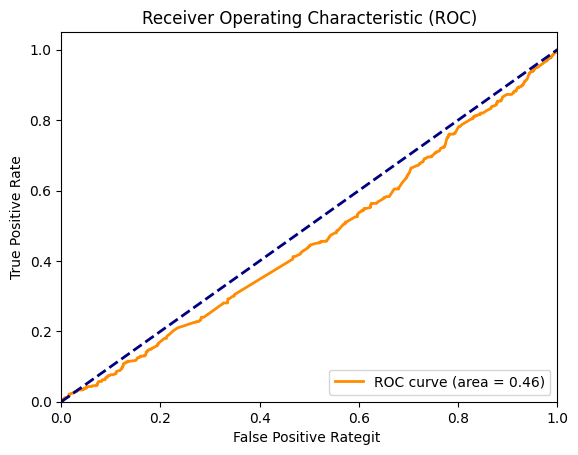

In [ ]:
from sklearn.metrics import roc_curve, auc

# best_clf.fit(X_train_new, y_train)

# Predict on validation set

y_pred_2 = best_clf_2.predict_proba(X_val_2)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_2, y_pred_2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rategit ')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('./images/ensembling.jpg')
plt.show()